In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition

drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Notes** 



1.   Data Reading & basic preprocessing


    *   read all dataset files 
    *   join all files into single data frame
    *   summarize info of 'in_time.csv and out_time.csv' in 3 columns in time mean, outtime mean and attendace
    *   remove nan values.


    Note data_vis (dataframe) is the output of this stage and it is often used in visualization;
  
2. data visualazation and gain insights from data

2.   classifier Data processing 


    *   one hot encoding
    *   remove redundant features
    *   min max normalization
    
    Note data (dataframe ) is the output of this stage

3.   classifier building
4.   selected model performace
5.   conclusions





#Data Reading & Basic preprocessing

In [0]:
#survey_dir="/content/drive/My Drive/colab/Bigdata/employee_survey_data.csv"
#general_dir="/content/drive/My Drive/colab/Bigdata/general_data.csv"
#manager_dir="/content/drive/My Drive/colab/Bigdata/manager_survey_data.csv"
#in_dir="/content/drive/My Drive/colab/Bigdata/in_time.csv"
#out_dir="/content/drive/My Drive/colab/Bigdata/out_time.csv"
survey_dir="/content/drive/My Drive/Bigdata/employee_survey_data.csv"
general_dir="/content/drive/My Drive/Bigdata/general_data.csv"
manager_dir="/content/drive/My Drive/Bigdata/manager_survey_data.csv"
in_dir="/content/drive/My Drive/Bigdata/in_time.csv"
out_dir="/content/drive/My Drive/Bigdata/out_time.csv"


survey=pd.read_csv(survey_dir)
general=pd.read_csv(general_dir)
manager=pd.read_csv(manager_dir)
inTime=pd.read_csv(in_dir)
outTime=pd.read_csv(out_dir)

inTime.rename(columns={"Unnamed: 0":"EmployeeID"},inplace=True)
outTime.rename(columns={"Unnamed: 0":"EmployeeID"},inplace=True)

for df in [survey,general,manager,inTime,outTime]:
  df.set_index("EmployeeID",inplace=True)

survey=survey.merge(general,on="EmployeeID")
original_data=survey.merge(manager,on="EmployeeID")
original_data.rename(columns={'JobInvolvement':'ManagerJobInvolvement','PerformanceRating':'ManagerPerformanceRating'},inplace=True)
#drop totalallu not neccessary columns
dropped_columns=['EmployeeCount','StandardHours','Over18']
original_data.drop(dropped_columns,axis=1,inplace=True) 
original_data.dropna(inplace=True)

# print(original_data.isna().sum())
original_data

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,ManagerJobInvolvement,ManagerPerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3,3
2,3.0,2.0,4.0,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,2,4
3,2.0,2.0,1.0,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,3,3
4,4.0,4.0,3.0,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,2,3
5,4.0,1.0,3.0,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,3.0,4.0,3.0,29,No,Travel_Rarely,Sales,4,3,Other,Female,2,Human Resources,Single,35390,1.0,18,0,6.0,2,6,1,5,2,3
4406,4.0,1.0,3.0,42,No,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,Single,60290,3.0,17,1,10.0,5,3,0,2,3,3
4407,4.0,4.0,3.0,29,No,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,Divorced,26790,2.0,15,0,10.0,2,3,0,2,2,3


#Feature engineering

In [0]:
# get working hourse mean feature to replace in time and out time as it encode all info neded by these tables
def get_working_hours_mean():
  assert(outTime.isna().equals(inTime.isna()))
  dummyDateTime = "2015-01-02 09:43:45" # dummy datetime
  oT = outTime.dropna(axis=1,how='all').fillna(value=dummyDateTime).apply(pd.to_datetime)
  iT = inTime.dropna(axis=1,how='all').fillna(value=dummyDateTime).apply(pd.to_datetime)
  return (oT-iT).mean(axis=1)/datetime.timedelta(hours=1)

original_data["WorkingHoursMean"] = get_working_hours_mean()


In [0]:
# data_vizu is copy from original data and used only for visualization
data_visu=original_data.dropna() # can be modifed usig data imputations 
data_visu.describe()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,ManagerJobInvolvement,ManagerPerformanceRating,WorkingHoursMean
count,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000
mean,2.723953,2.724884,2.761163,36.926977,9.197907,2.913256,2.066977,65059.844186,2.690000,15.210698,0.795349,11.285116,2.796279,7.026047,2.190000,4.132558,2.728837,3.153953,7.316378
std,1.093802,1.101875,0.707800,9.146517,8.097059,1.024774,1.106633,47045.398914,2.495764,3.662777,0.853534,7.790052,1.290142,6.148036,3.230818,3.565831,0.710769,0.360946,1.332139
min,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.416880
25%,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.000000,29260.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,6.278232
50%,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,2.000000,49360.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,7.016215
75%,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,3.000000,83802.500000,4.000000,18.000000,1.000000,15.000000,3.000000,9.250000,3.000000,7.000000,3.000000,3.000000,7.912287
max,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,10.937261


# Data Visualizations & Insights

## correlation matrix

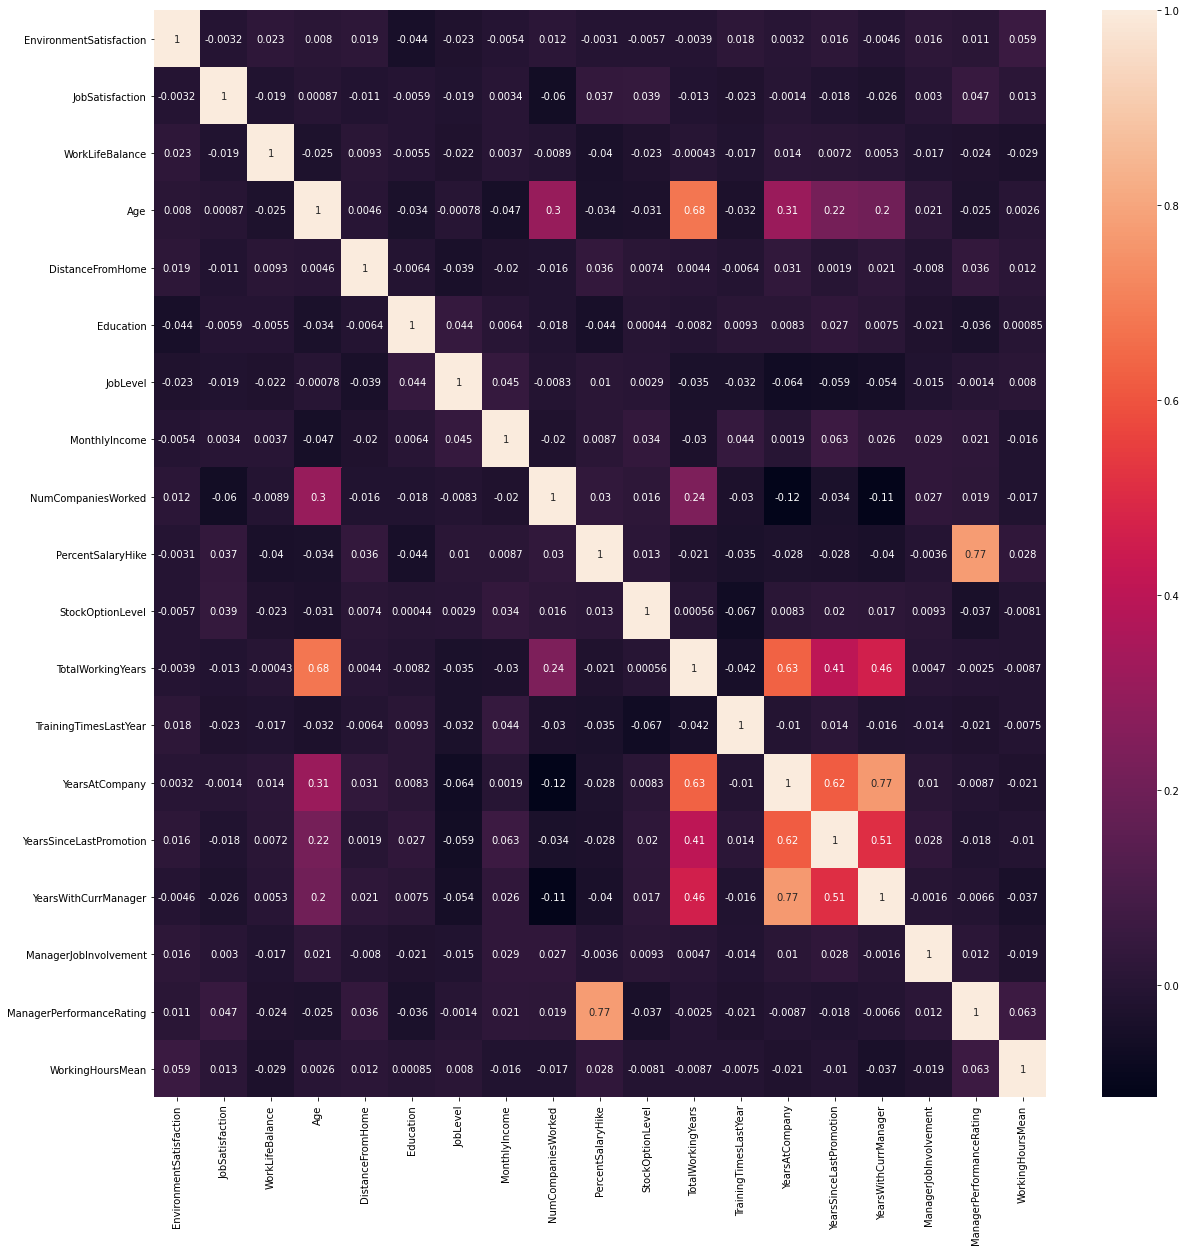

In [0]:
fig, ax = plt.subplots(figsize=(20,20)) 
sn.heatmap(data_visu.corr(),annot=True, ax=ax)

## data set not balanced 

[3605  695]


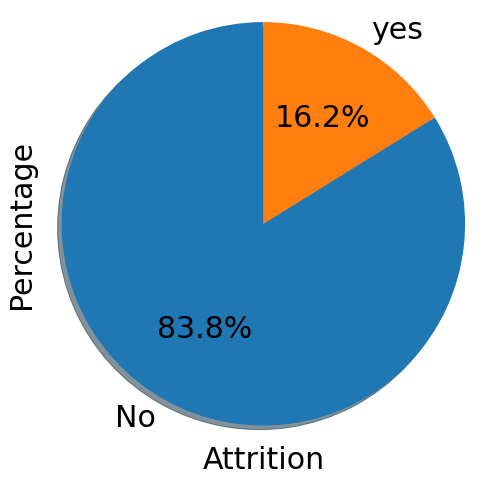

In [0]:
dataPie = data_visu[['Attrition']]
bars_label=sorted(dataPie['Attrition'].value_counts().index.to_list())
size=dataPie['Attrition'].value_counts().sort_index(ascending=True).to_numpy()
print(size)
labels=['No','yes']
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(size, labels=labels,
        shadow=True, startangle=90, autopct='%1.1f%%',textprops={'fontsize': 30})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_ylabel('Percentage', fontsize = 30) # Y label
ax.set_xlabel('Attrition', fontsize = 30) # X labe
plt.show()


In [0]:
def attr_perc_plot(data=None, level=0, field=None, x=None, rot=None):
  '''
    this is different of plot_histo_bar(hue="Attrition").
    this function plot the perc of attrition in every group independently.
    in other words this map to the difference of bars in every group if 
    plot_histo_bar(hue="Attrition") is used
  '''
  field = field or x # to support both key word arg
  data = data.copy()
  data["count"] = 1
  dfc = pd.DataFrame(data.groupby([field, "Attrition"]).count()["count"])
  a = []
  for fieldVal, new_df in dfc.groupby(level=level):
    new_df.reset_index(inplace=True)
    # print(new_df)
    # print(new_df.iloc[0, 1])
    percAttr = new_df.iloc[1,2] / (new_df.iloc[0,2] + new_df.iloc[1,2])*100
    a.append([fieldVal, percAttr])
  df = pd.DataFrame(a, columns=[field, "Attr perc"])
  return df.plot.bar(x=field, y="Attr perc", rot=rot, title=field)

def plot_histo_bar(data, x, hue, label="histo"):
  (data_visu[x]
  .groupby(data_visu[hue])
  .value_counts(normalize=True)
  .rename(label)
  .reset_index()
  .pipe((sn.barplot, "data"), x=x, y=label, hue=hue))
  plt.show()

def plot_bar(data,label,x_axis,barWidth=0.3,fontsize='medium',distance=1,colors=['r','g']):
  data = data[[label,x_axis]]
  bars_label=sorted(data[x_axis].value_counts().index.to_list())
  offset=0

  for index, item in enumerate(data[label].unique(), start=0):
    yes=data[data[label]==item]
    bars1=yes[x_axis].value_counts().sort_index(ascending=True).to_numpy()
    bars1= bars1/bars1.sum()
    r1 = np.arange(len(bars1))*distance

    r1=r1+offset
    plt.bar(r1, bars1, color=colors[index], width=barWidth, edgecolor='white', label=item)
    offset=offset+barWidth
  
  # Add xticks on the middle of the group bars
  plt.xlabel(x_axis, fontweight='bold',)
  plt.ylabel('Histogram', fontweight='bold')
  plt.xticks([r*distance + barWidth for r in range(len(bars1))],bars_label,fontsize=fontsize)
  plt.legend()
  plt.show()

def reldistplot(data, x, groupby, legends=None):
  data = data[[x, groupby]]
  catValues = sorted(data_visu[groupby].unique().tolist())
  legends = legends or catValues
  for cat, label in zip(catValues, legends):
    sn.distplot(data[data[groupby] == cat][x], hist=False, label=label)
  plt.show()



## **Personal info effects on attrition**

### Martial Status

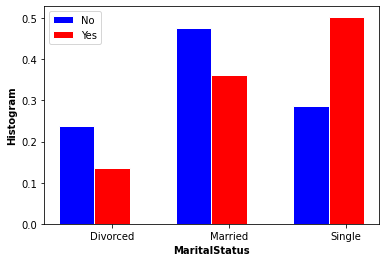

In [0]:
plot_bar(data_visu,'Attrition','MaritalStatus',colors=["blue","red"])



*   single people leave the work the most



### Number of company worked on

[Text(0, 0.5, 'Pdf')]

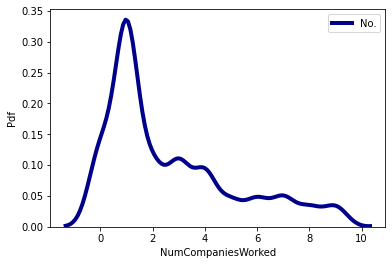

In [0]:
dataNo=data_visu['NumCompaniesWorked']
ax=sn.distplot(dataNo, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label='No.')
ax.set(ylabel="Pdf")

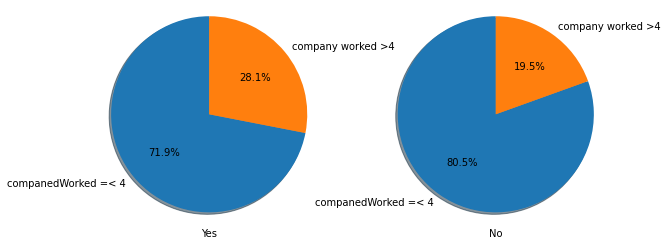

In [0]:
dataPie = data_visu[['Attrition','NumCompaniesWorked']]
dataPie=dataPie[dataPie['Attrition']=='Yes']
bars_label=sorted(dataPie['NumCompaniesWorked'].value_counts().index.to_list())
size=dataPie['NumCompaniesWorked'].value_counts().sort_index(ascending=True).to_numpy()
size_new =[size[0]+size[1]+size[2]+size[3]+size[4],size[5]+size[6]+size[7]+size[8]+size[9]]
labels=['companedWorked =< 4','company worked >4']
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie(size_new, labels=labels,
        shadow=True, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(xlabel="Yes")




### Age

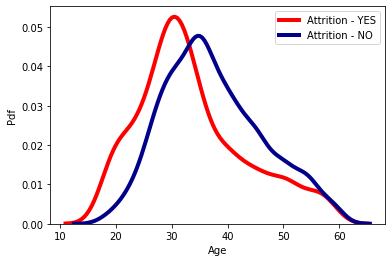

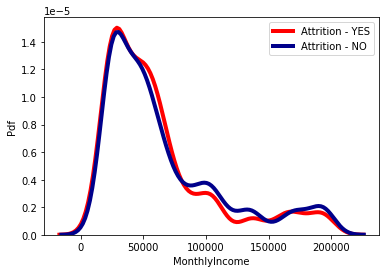

In [0]:
dataYes=data_visu[data_visu['Attrition']=='Yes']
sn.distplot(dataYes['Age'], hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label="Attrition - YES")

dataNo=data_visu[data_visu['Attrition']=='No']
ax=sn.distplot(dataNo['Age'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label='Attrition - NO',)
ax.set(ylabel="Pdf")

plt.show()


* Oboviusly younger people have higher probabilty to leave company.

## **Relation between login and logout times and Attrition (Working hours Mean)**

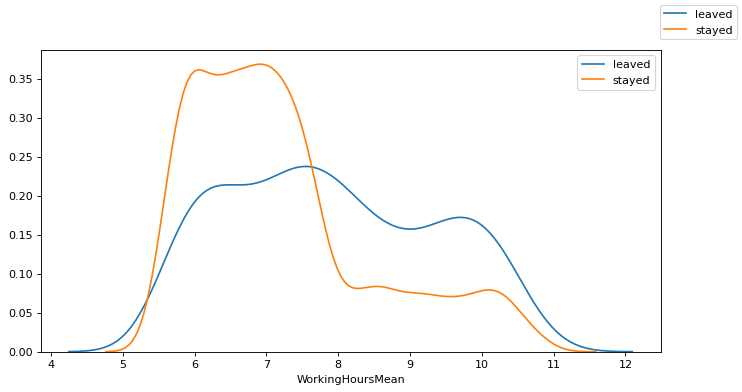

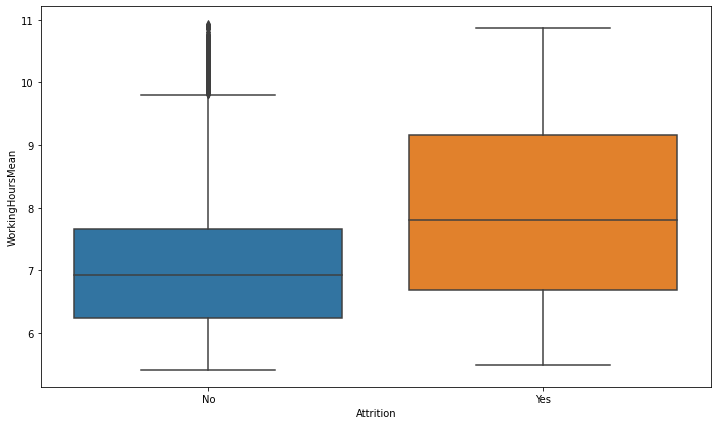

In [0]:
working_hours = data_visu["WorkingHoursMean"]
leaved = working_hours[data_visu["Attrition"]=="Yes"]
stayed = working_hours[data_visu["Attrition"]=="No"]
fig = plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
sn.distplot(leaved,hist=False, label='leaved')
sn.distplot(stayed,hist=False, label='stayed')
fig.legend(loc='upper right')
fig.show()
plt.figure(figsize=(12,7))
sn.boxplot(y='WorkingHoursMean',x='Attrition',data=data_visu)

### **Explore why working hours mean matters**

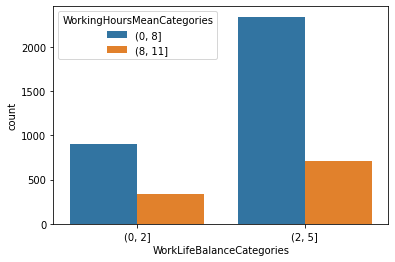

In [0]:
data_visu_tmp = data_visu[["WorkingHoursMean","WorkLifeBalance","MonthlyIncome"]].copy()
data_visu_tmp["WorkingHoursMeanCategories"]=pd.cut(data_visu_tmp["WorkingHoursMean"], bins=[0,8,11])
data_visu_tmp["WorkLifeBalanceCategories"]=pd.cut(data_visu_tmp["WorkLifeBalance"], bins=[0,2,5])

# work life balance
sn.countplot(data=data_visu_tmp[["WorkingHoursMeanCategories","WorkLifeBalanceCategories"]],hue='WorkingHoursMeanCategories',x='WorkLifeBalanceCategories')

10.937261267291111


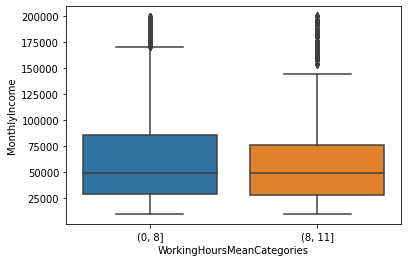

In [0]:
#monthly income
sn.boxplot(y='MonthlyIncome',x='WorkingHoursMeanCategories',data=data_visu_tmp)
print(max(data_visu_tmp["WorkingHoursMean"]))

* Mean of working hours has effect on attrittion the graphs above tells that the people working less tends to stay in company and this is confirmed by feature importance report (at last section)
* That is because they have good work life balance as ratio between people that work below 8 and work above 8 gets bigger with higher work life blanace survey raiting 
* Also company doens't give good substittion in terms of income for working more. that is obvoiuse from box plot people work less than 8 have income mean almost same as people work for more than 8 and larger deviation


## **Relation between BusinessTravel and Attrition**

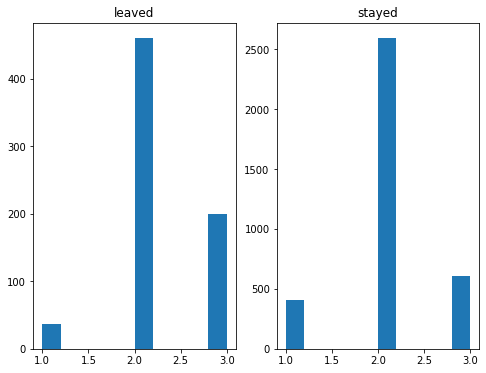

In [0]:
BusinessTravel = data_visu["BusinessTravel"].replace({'Travel_Frequently':3,'Travel_Rarely':2,'Non-Travel':1})
leaved = BusinessTravel[data_visu["Attrition"]=="Yes"]
stayed = BusinessTravel[data_visu["Attrition"]=="No"]

f = plt.figure(figsize=(8,6))
sp1 = f.add_subplot(121)
sp1.hist(leaved)
sp1.set_title('leaved')

sp2 = f.add_subplot(122)
sp2.hist(stayed, label='stayed')
sp2.set_title('stayed')

f.show()

* seems that business travel has nothing to do with Attrition the almost has same distribution, most is Travel_Rarely and fewer Travel_Frequently and fewer Non-Travel
* And  this is confirmed by feature importance report above

## **Relation between Department and Attrition**

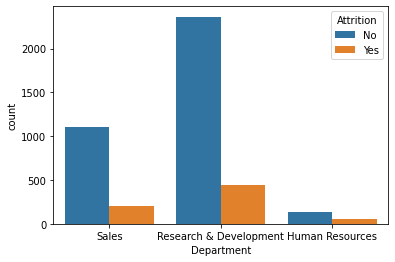

In [0]:
sn.countplot(data=data_visu,x='Department',hue='Attrition')

* Seems most people left were form R&D dep but this not useful as this department has the largest number of employees and also there are alot stayed
* So let's examine something more useful like the ratio


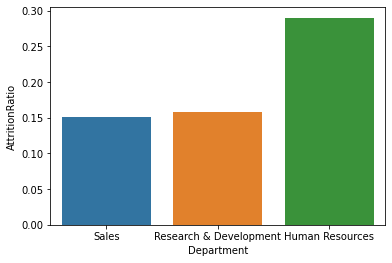

In [0]:
def getDepAttrRatio():
  depAttritionRatio = []
  for dep in data_visu["Department"].unique():
    total = data_visu[data_visu["Department"]==dep]
    leavedCount = len(total[total["Attrition"]=="Yes"])
    depAttritionRatio.append([dep,leavedCount/len(total)])
  return pd.DataFrame(depAttritionRatio,columns=["Department","AttritionRatio"])
sn.barplot(x='Department',y='AttritionRatio', data=getDepAttrRatio())
# attr_perc_plot(data=data_visu, x="Department"); plt.show()

* It turns out the bigger ration of Attrition is in HR department

## satisfaction effects on attrition

### years since last promotion

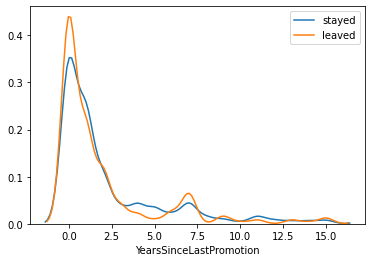

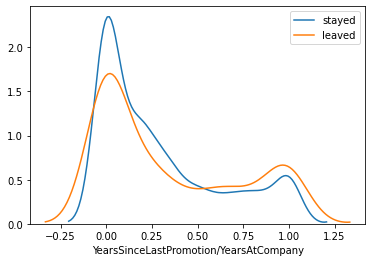

In [0]:
reldistplot(data_visu, x="YearsSinceLastPromotion", groupby="Attrition", legends=["stayed", "leaved"])

data_visu['YearsSinceLastPromotion/YearsAtCompany'] = data_visu["YearsSinceLastPromotion"].div(data_visu["YearsAtCompany"])
reldistplot(data_visu, x='YearsSinceLastPromotion/YearsAtCompany', groupby="Attrition", legends=["stayed", "leaved"])



first distribution showing that no effect of years since last promotion in attrition, as the two dist as almost the same.
But when we divide it to the number of years stayed at company, we can find a light effect of this ratio, and in after certain value of this ratio (about 0.51) the prob that the employee leave becomes higher

almost all three last levels are the same. But if the employee give 1 as the rating it will really matter

### Jop and environment satisfaction

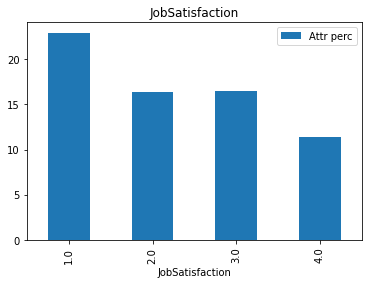

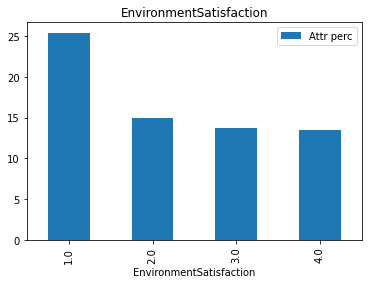

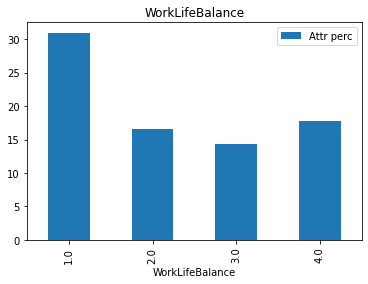

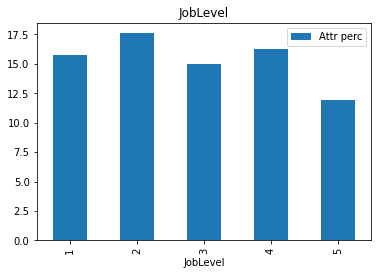

In [0]:
attr_perc_plot(data=data_visu, x="JobSatisfaction")
attr_perc_plot(data=data_visu, x="EnvironmentSatisfaction")
attr_perc_plot(data=data_visu, x="WorkLifeBalance")
attr_perc_plot(data=data_visu, x="JobLevel")

we can conclude following facts from comparing there plots to each other:
- job level is not affecting the attrition at all
- the work life balance matters more than env and job satisfaction
- almost all three last levels are the same. But if the employee give 1 as the rating it will really matter 

## grouping of employees

### education, education field, department

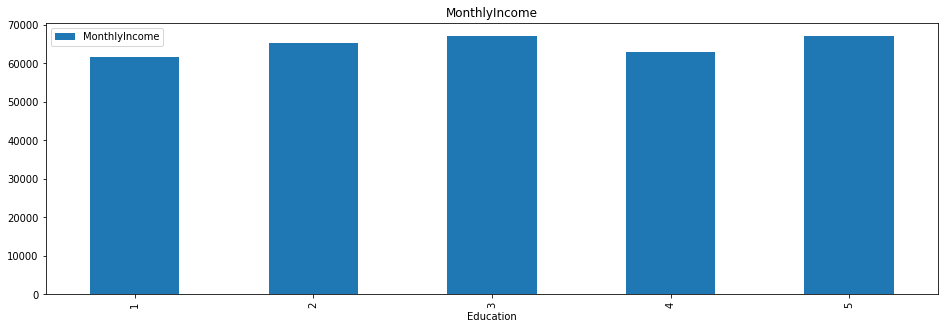

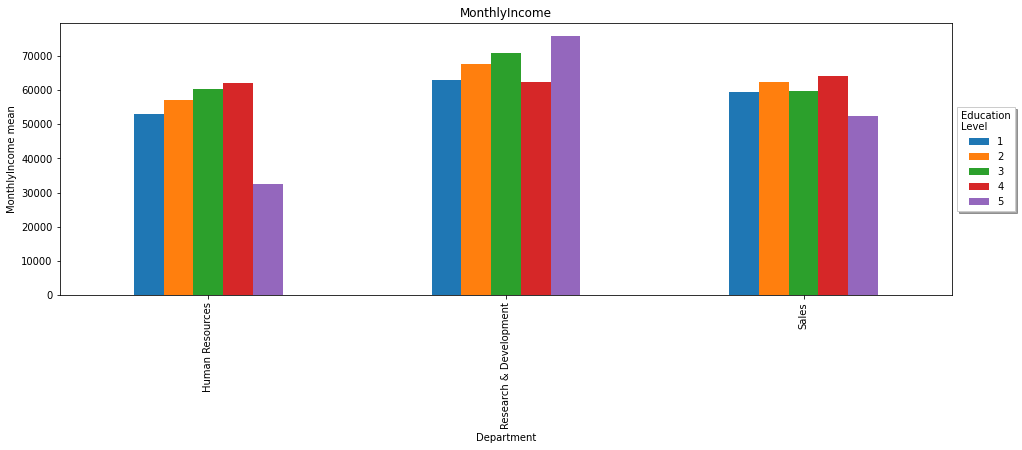

In [0]:
def means_plot(groupby, projection,data=data_visu, level=1, title=None,sort_values=False):
  data = data.groupby(groupby).mean()[projection]
  for target in projection:
    means = data.unstack(level=level) if len(groupby) > 1 else data
    if(sort_values):
      means.sort_values(projection, ascending = (False),inplace=True)
    ax = means.plot.bar(subplots=False, y=target, title=title or target, figsize=(16,5))
    if len(groupby) > 1:
      ax.legend(data.index.get_level_values(level).unique().tolist(),title=groupby[1]+"\nLevel", **legendkwargs())
      ax.set_ylabel(target + " mean")
    plt.show()
def legendkwargs(loc=None):
  return {
      "loc":loc or 'center left',
      "bbox_to_anchor":(1, 0.5),
      "ncol":1, 
      "fancybox":False, 
      "shadow":True
  }
means_plot(groupby=["Education"], level=1, projection=["MonthlyIncome"])
means_plot(groupby=["Department", "Education"], level=1, projection=["MonthlyIncome"])

plt.show()

we can see that the education level has no significant effect on monthly income in this company. they all take the same average income approximatly

when we expand further to see in every departement, how the income is affected by the education level: we can conclude also that every departement is constant.

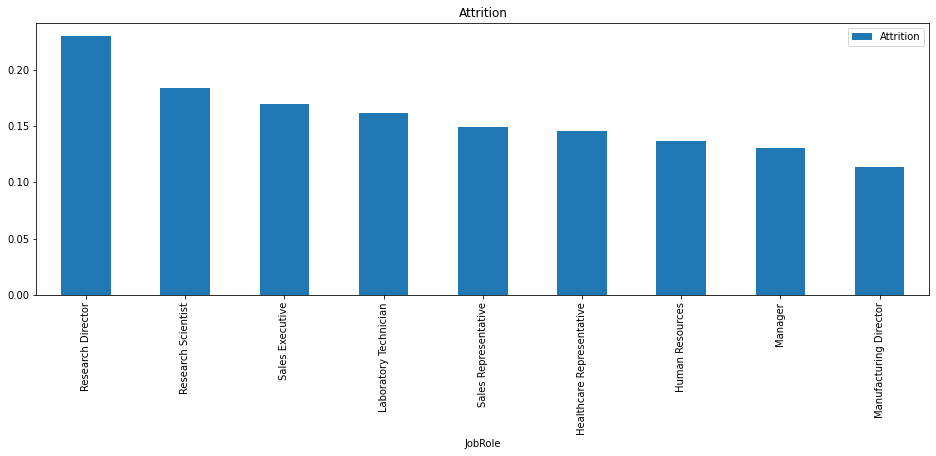

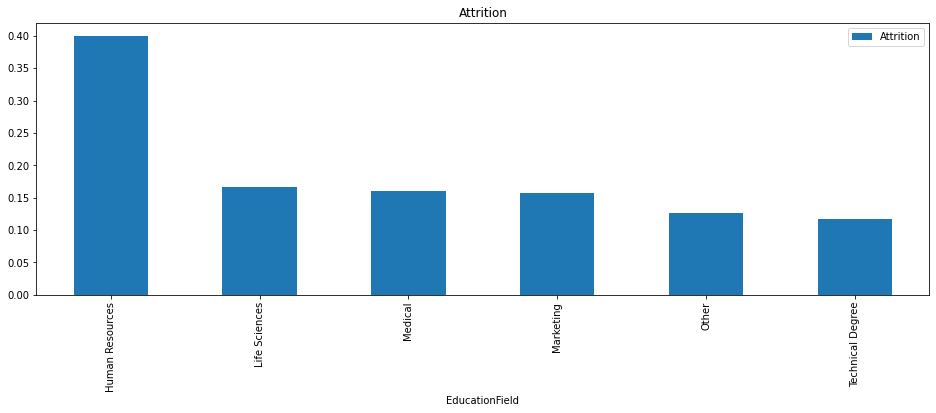

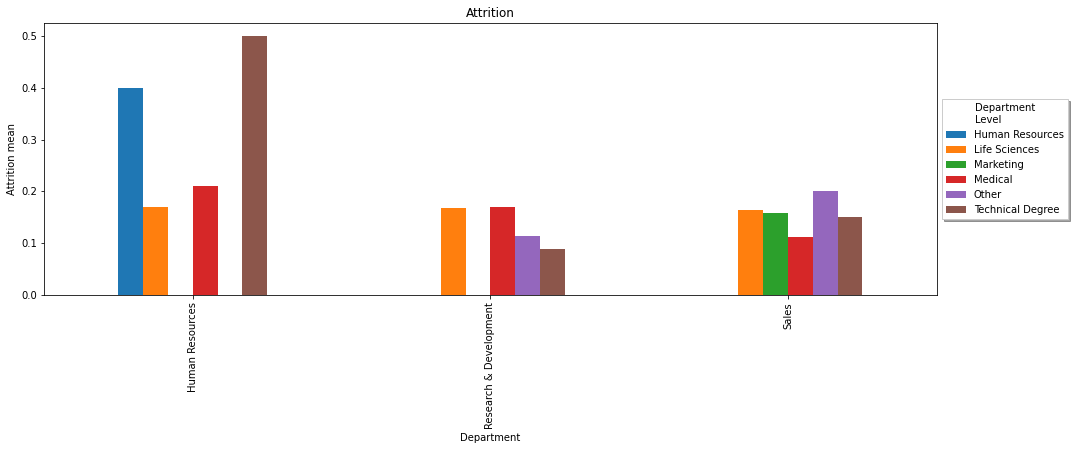

In [0]:
data = data_visu.copy()
data['Attrition'] = (data['Attrition']=="Yes").astype(int)
means_plot(groupby=["JobRole"], level=0, projection=["Attrition"], data=data,sort_values=True)
means_plot(groupby=["EducationField"], level=0, projection=["Attrition"], data=data,sort_values=True)
means_plot(groupby=["EducationField", "Department"], level=0, projection=["Attrition"], data=data)

- Research director rule have most attrition prob value, company may want to explore more about this rule
- HR departement have most attirtion value

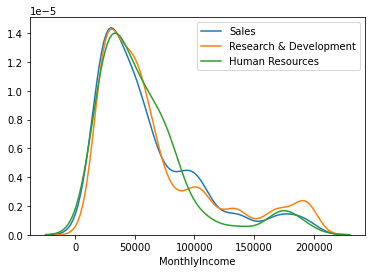

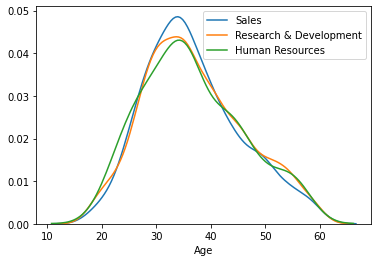

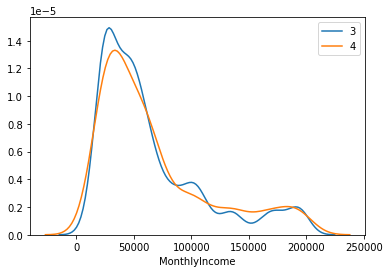

In [0]:
def dist_plot(data=data_visu, groupby="Department", target="MonthlyIncome", bins=None):
  for dep in data_visu[groupby].unique():
    dfSeries = data_visu[data_visu[groupby] == dep][target]
    # print(dfSeries.shape)
    sn.distplot(dfSeries, hist=False, label=dep, bins=bins)
    # break
  plt.show()

dist_plot()
dist_plot(target="Age")
dist_plot(groupby="ManagerPerformanceRating")

the distribution of the age is almost the same all departements and also the income
we can find that performance measure of the manager doesn't affet the income of the employee


## manager survey effect

In [0]:
print(pd.unique(data_visu["ManagerJobInvolvement"].values))

[3 2 4 1]


##Manager Job Involvement Effect On Attrition


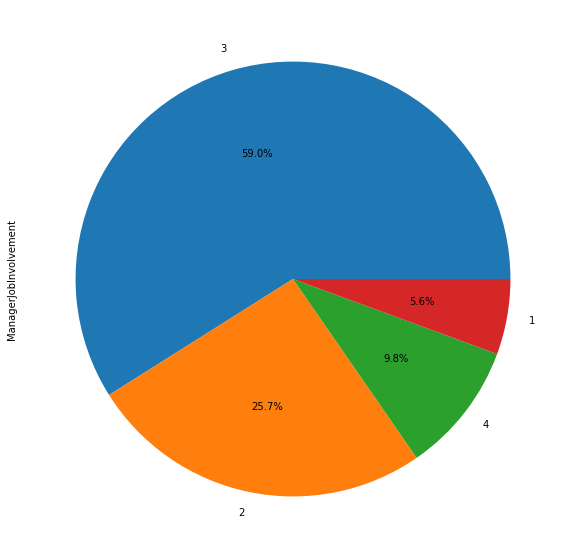

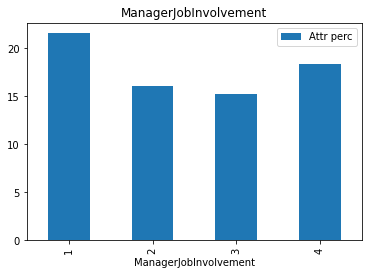

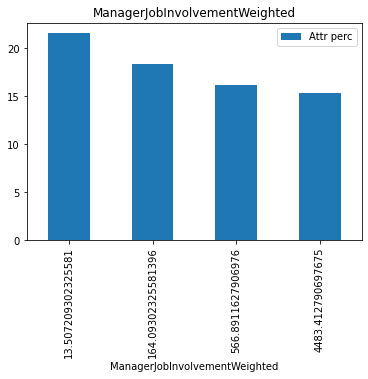

In [0]:
#Explore Data

fig, ax = plt.subplots()
data_visu['ManagerJobInvolvement'].value_counts().plot(ax=ax, kind='pie', autopct='%1.1f%%',figsize=(10, 10))
plt.show()
# sn.countplot(x="Attrition", hue="ManagerJobInvolvement", data=data_visu)
# reldistplot(data=data_visu,x="ManagerJobInvolvement",groupby='Attrition',legends=["stayed", "leaved"])

#Draw Job involvement against Attrition
attr_perc_plot(data=data_visu,field="ManagerJobInvolvement")
plt.show()

#Draw Weighted Job involvement against Attrition
tmp_data_visu = data_visu[['Attrition']].copy()
rait_count = pd.DataFrame(data_visu['ManagerJobInvolvement'].value_counts())
total_count = sum(rait_count['ManagerJobInvolvement'])
tmp_data_visu["ManagerJobInvolvementWeighted"] = data_visu['ManagerJobInvolvement'].apply(func=lambda x: x * (rait_count.at[x,"ManagerJobInvolvement"]**2)/total_count)
attr_perc_plot(data=tmp_data_visu,field="ManagerJobInvolvementWeighted")
plt.show()


# Classifier Data Preprocessing

In [0]:
data = original_data.copy()

min_max_columns = ['EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education','JobLevel',
       'MonthlyIncome','NumCompaniesWorked','PercentSalaryHike','StockOptionLevel',
       'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
       'YearsWithCurrManager','ManagerJobInvolvement','ManagerPerformanceRating',"WorkingHoursMean"]
y_column=['Attrition']

one_hot_columns = ['BusinessTravel',	'Department', 'EducationField','Gender','JobRole','MaritalStatus']

# data normalization
data[min_max_columns]=MinMaxScaler().fit_transform(data[min_max_columns])

# encode categorical variables
one_hot = pd.get_dummies(data[one_hot_columns])
data= pd.concat([data,one_hot],axis=1)
data=data.drop(one_hot_columns,axis=1)

# encode y_column
data['Attrition']=(data['Attrition']=="Yes").astype(int)
data['Attrition']
data

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,ManagerJobInvolvement,ManagerPerformanceRating,WorkingHoursMean,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.666667,1.000000,0.333333,0.785714,0,0.178571,0.25,0.00,0.637546,0.111111,0.000000,0.000000,0.025,1.000000,0.025,0.000000,0.000000,0.666667,0.0,0.263270,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.666667,0.333333,1.000000,0.309524,1,0.321429,0.00,0.00,0.167457,0.000000,0.857143,0.333333,0.150,0.500000,0.125,0.066667,0.235294,0.333333,1.0,0.344014,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.333333,0.333333,0.000000,0.333333,0,0.571429,0.75,0.75,0.964666,0.111111,0.285714,1.000000,0.125,0.333333,0.125,0.000000,0.176471,0.666667,0.0,0.253461,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,1.000000,1.000000,0.666667,0.476190,0,0.035714,1.00,0.50,0.385045,0.333333,0.000000,1.000000,0.325,0.833333,0.200,0.466667,0.294118,0.333333,0.0,0.248594,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5,1.000000,0.000000,0.666667,0.333333,0,0.321429,0.00,0.00,0.070195,0.444444,0.071429,0.666667,0.225,0.333333,0.150,0.000000,0.235294,0.666667,0.0,0.445745,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.666667,1.000000,0.666667,0.261905,0,0.107143,0.50,0.25,0.133228,0.111111,0.500000,0.000000,0.150,0.333333,0.150,0.066667,0.294118,0.333333,0.0,0.307987,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4406,1.000000,0.000000,0.666667,0.571429,0,0.142857,0.75,0.00,0.264350,0.333333,0.428571,0.333333,0.250,0.833333,0.075,0.000000,0.117647,0.666667,0.0,0.525333,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4407,1.000000,1.000000,0.666667,0.261905,0,0.035714,0.75,0.00,0.087941,0.222222,0.285714,0.000000,0.250,0.333333,0.075,0.000000,0.117647,0.333333,0.0,0.087008,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


#Classifier

In [0]:
y=data[y_column] 
x=data.drop(y_column,axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,ManagerJobInvolvement,ManagerPerformanceRating,WorkingHoursMean,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4019,0.333333,1.000000,1.000000,0.880952,0.035714,0.50,0.00,0.093312,0.888889,0.142857,0.333333,0.475,0.333333,0.125,0.000000,0.235294,0.666667,0.0,0.101984,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1074,1.000000,0.333333,0.666667,0.714286,0.035714,0.50,0.25,0.277146,0.444444,0.214286,0.000000,0.725,0.500000,0.550,0.800000,0.529412,0.333333,0.0,0.071183,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1364,0.666667,0.333333,0.666667,0.404762,0.250000,0.00,0.50,0.144866,0.111111,0.214286,1.000000,0.250,0.333333,0.250,0.000000,0.352941,0.666667,0.0,0.266896,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2328,0.000000,1.000000,0.000000,0.380952,0.071429,0.50,0.25,0.054502,0.111111,0.000000,0.000000,0.025,0.333333,0.025,0.000000,0.000000,0.666667,0.0,0.249355,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1825,0.333333,0.333333,0.666667,0.238095,0.000000,0.25,0.00,0.064350,0.111111,0.071429,0.000000,0.200,0.500000,0.200,0.466667,0.294118,0.333333,0.0,0.778123,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539,0.000000,0.666667,0.333333,0.047619,0.178571,0.50,1.00,0.388784,0.111111,0.428571,0.000000,0.050,0.833333,0.050,0.066667,0.117647,0.666667,0.0,0.146931,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
485,0.000000,1.000000,0.666667,0.761905,0.928571,0.50,0.25,0.121169,0.444444,0.785714,0.333333,0.200,0.500000,0.025,0.000000,0.000000,1.000000,1.0,0.081720,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3180,1.000000,1.000000,1.000000,0.619048,0.035714,0.25,0.00,0.158083,0.444444,0.214286,0.333333,0.650,0.333333,0.050,0.000000,0.058824,0.666667,0.0,0.552467,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


## Dummy Classifier
classifiers (random and most_freqeunt) 
to be as bench mark for any classifier and experminet

In [0]:
from sklearn.dummy import DummyClassifier

stratiges= ['uniform','most_frequent']
for strategy in stratiges:
  print('classifier :  ',strategy)
  clf=DummyClassifier(strategy=strategy)
  clf.fit(x_train, y_train)
  y_pre=clf.predict(x_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pre).ravel()
  print(tp,tn,fp,fn)
  print(f1_score(y_test,y_pre))
  print(accuracy_score(y_test,y_pre))


classifier :   uniform
30 185 186 29
0.2181818181818182
0.5
classifier :   most_frequent
0 371 0 59
0.0
0.8627906976744186


## Logistic Regression

In [0]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pre = lr.predict(x_test)

confusion_matrix(y_test, y_pre)
tn, fp, fn, tp = confusion_matrix(y_test, y_pre).ravel()
print(tp,tn,fp,fn)
print(f1_score(y_test,y_pre))
print(accuracy_score(y_test,y_pre))

17 362 9 42
0.4
0.8813953488372093


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## PCA Visualization

In [0]:
standardized_data = StandardScaler().fit_transform(x)
print(standardized_data.shape)


(4300, 45)


In [0]:
pca = decomposition.PCA()
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data_all = pca.fit_transform(x)
print(pca_data_all[0])

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data_all.shape)


[0.62857989 1.01524032]
shape of pca_reduced.shape =  (4300, 2)


(4300, 1)


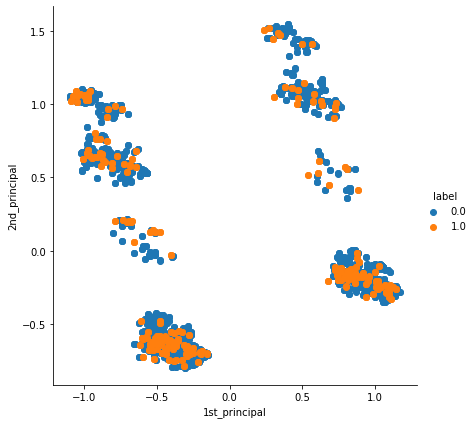

In [0]:

print(y.shape)
pca_data_all = np.vstack((pca_data_all.T, y.T)).T

# creating a new data fram which help us in ploting the result data
pca_df_all = pd.DataFrame(data=pca_data_all, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df_all, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()


## Neural Network

In [0]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100,50,25),activation='tanh', random_state=42,verbose=True,)
clf.fit(x_train, y_train.values.ravel())


MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 25), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [0]:
y_pre=clf.predict(x_test)

In [0]:
confusion_matrix(y_test, y_pre)
tn, fp, fn, tp = confusion_matrix(y_test, y_pre).ravel()
print(tp,tn,fp,fn)
print(f1_score(y_test,y_pre))
print(accuracy_score(y_test,y_pre))


56 368 3 3
0.9491525423728814
0.986046511627907


## Confusion matrix and ROC

No handles with labels found to put in legend.


[[368   3]
 [  3  56]]
Model: ROC AUC=0.969


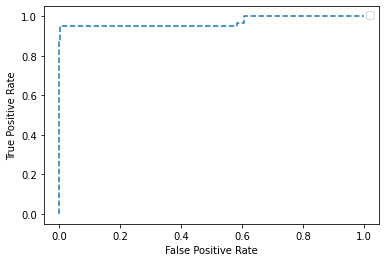

In [0]:
# Confution matrix
print(confusion_matrix(y_test, y_pre))

from sklearn.metrics import roc_curve, roc_auc_score

# predict probabilities
probas = clf.predict_proba(x_test)

# keep probabilities for the positive outcome only
probas = probas[:, 1]

# print scores
print('Model: ROC AUC=%.3f' % (roc_auc_score(y_test, probas)))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, probas)

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
plt.show()

#Model based insights

## Examining Feature importance with GBC (as logistic didn't achieve good performance)

0.9739130434782608
0.9930232558139535


<BarContainer object of 45 artists>

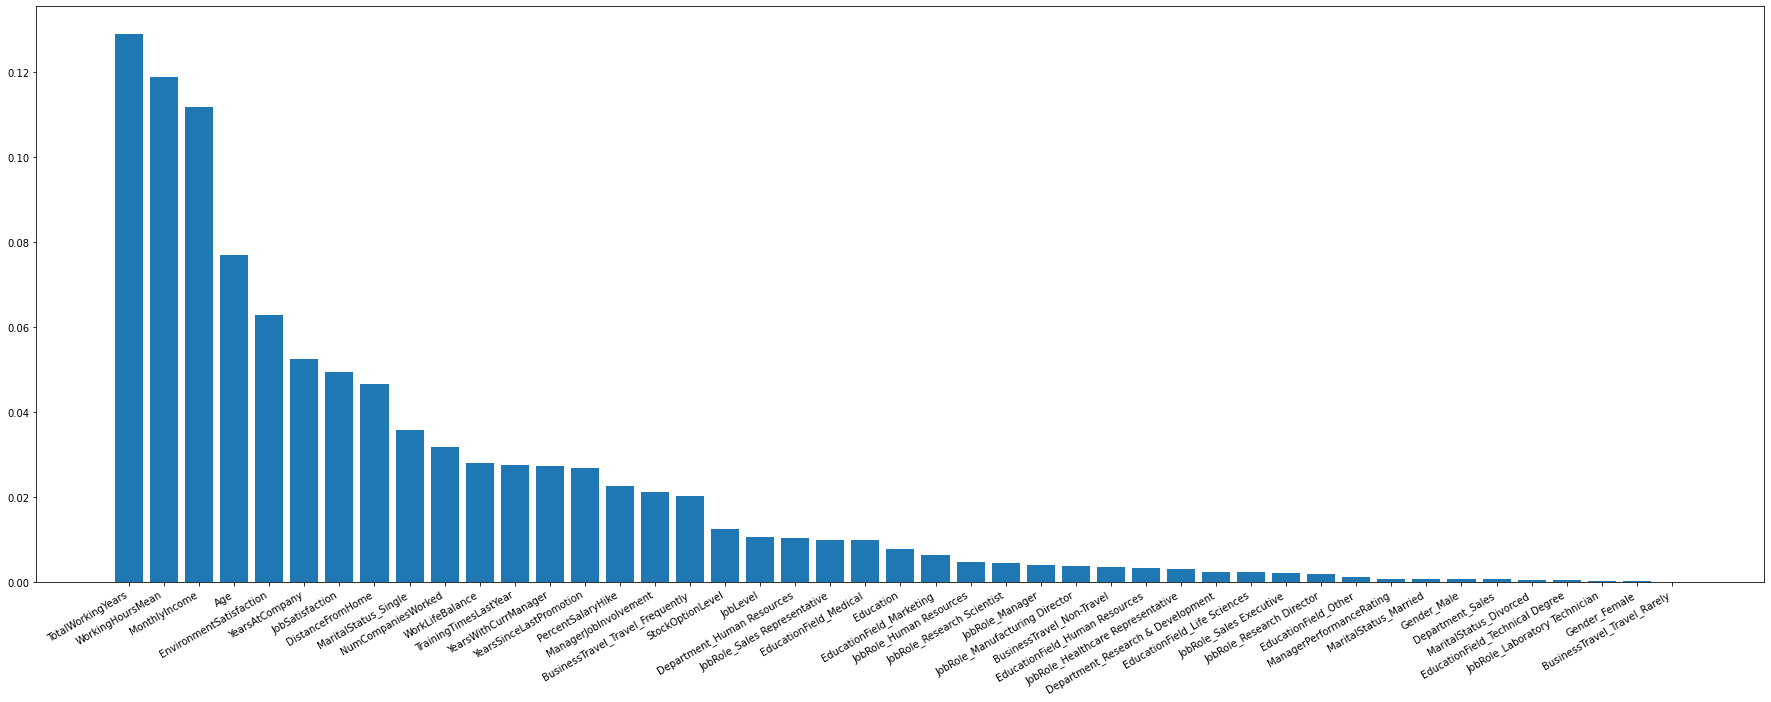

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=500,learning_rate=.7)
gbclf=gb.fit(x_train, y_train.values.ravel())

y_pre2=gbclf.predict(x_test)
y_pre2
confusion_matrix(y_test, y_pre2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pre2).ravel()
print(f1_score(y_test,y_pre2))
print(accuracy_score(y_test,y_pre2))


fig= plt.figure(figsize=(30,10))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
feature_importances = sorted(zip(x_train.columns, gb.feature_importances_),key=lambda x:x[1],reverse=True)
fig.autofmt_xdate()
plt.bar(*zip(*feature_importances))

### Neural Network Based on Personal Info

In [0]:
data_trial = data.copy()
personal_columns=['Age',	'DistanceFromHome',	'NumCompaniesWorked'	,'Gender_Female','Gender_Male','MaritalStatus_Divorced',
'MaritalStatus_Married'	,'MaritalStatus_Single',"Attrition"]
data_trial = data_trial[personal_columns]
y=data_trial[y_column] 
x=data_trial.drop(y_column,axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train

,Age,DistanceFromHome,NumCompaniesWorked,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeID,,,,,,,,
4019,0.880952,0.035714,0.888889,1,0,0,1,0
1074,0.714286,0.035714,0.444444,1,0,0,1,0
1364,0.404762,0.250000,0.111111,1,0,0,1,0
2328,0.380952,0.071429,0.111111,0,1,0,0,1
1825,0.238095,0.000000,0.111111,1,0,0,1,0
...,...,...,...,...,...,...,...,...
3539,0.047619,0.178571,0.111111,0,1,0,0,1
485,0.761905,0.928571,0.444444,0,1,0,1,0
3180,0.619048,0.035714,0.444444,0,1,0,1,0


In [0]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100,50,25),activation='tanh', random_state=42,verbose=True,)
clf.fit(x_train, y_train)
y_test_pre=clf.predict(x_test)
y_train_pre=clf.predict(x_train)

print("on Train\n-------------------------")
confusion_matrix(y_train, y_train_pre)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pre).ravel()
print(tp,tn,fp,fn)
print(f1_score(y_train,y_train_pre))
print(accuracy_score(y_train,y_train_pre))

print("\non Test\n-------------------------")
confusion_matrix(y_test, y_test_pre)
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pre).ravel()
print(tp,tn,fp,fn)
print(f1_score(y_test,y_test_pre))
print(accuracy_score(y_test,y_test_pre))


########### we see that accuracy is better than random or most_frequent classifiers and same for f1 score


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


on Train
-------------------------
518 3174 60 118
0.8533772652388797
0.9540051679586563

on Test
-------------------------
36 354 17 23
0.6428571428571429
0.9069767441860465


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)




---
We have seen that using only personal data ----> not related to work

*   it is beter thant (random guessing and prediction that high frequency class)
*   and also better than logistic regression on the all dataset


i think the most important features 
(Martial Status, Numberof company worked on , age)



